c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


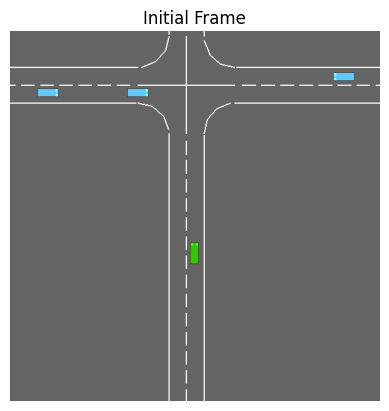

In [1]:
# Import libraries and make sure highway-env is installed properly
import gymnasium
import highway_env
import numpy as np
import matplotlib.pyplot as plt

# Create the environment with visual rendering
env = gymnasium.make("intersection-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

Environment Information:
{'action': {'lateral': False,
            'longitudinal': True,
            'target_speeds': [0, 4.5, 9],
            'type': 'DiscreteMetaAction'},
 'arrived_reward': 1,
 'centering_position': [0.5, 0.6],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'destination': 'o1',
 'duration': 13,
 'high_speed_reward': 1,
 'initial_vehicle_count': 10,
 'manual_control': False,
 'normalize_reward': False,
 'observation': {'absolute': True,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'flatten': False,
                 'obs

In [3]:
import torch
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name


True
NVIDIA GeForce RTX 3080


In [4]:
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
# === Create wrapped evaluation env ===
def make_env(render_mode=None):
    def _init():
        env = gym.make("intersection-v0", render_mode=render_mode)
        return Monitor(env)
    return _init

In [5]:
import os
import json
import optuna
import torch
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner

# === Configuration ===
SAVE_DIR = "../trained_models/intersection/DQN/"
os.makedirs(SAVE_DIR, exist_ok=True)

FINE_MODEL_PATH = os.path.join(SAVE_DIR, "DQN_best_fine.zip")

# === Globals to hold best model ===
best_reward = -float("inf")

# === Optuna Callback for pruning ===
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=2000, n_eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=self.n_eval_episodes, deterministic=True)
            self.trial.report(reward, self.n_calls)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return True
# === Objective Function ===
def objective(trial):
    global best_reward

    # fine tuning: explore main params
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.85, 0.999)
    net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
    gamma = trial.suggest_float("gamma", 0.85, 0.999)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    config = {
        "learning_rate": learning_rate,
        "gamma": gamma,
        "net_arch": net_arch,
        "exploration_fraction": exploration_fraction,
        "batch_size": batch_size,
    }

    # Create env and model
    env = make_vec_env(make_env(), n_envs=1)
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        exploration_fraction=config["exploration_fraction"],
        batch_size=config["batch_size"],
        verbose=0,
        tensorboard_log=f"../tensorboard_logs/intersection/DQN_phase_fine/",
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    print(f"Starting training for trial {trial.number}...")
    model.learn(total_timesteps=10_000, callback=OptunaCallback(trial))

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    trial.set_user_attr("mean_reward", mean_reward)

    # Save best model immediately when improved
    if mean_reward > best_reward:
        best_reward = mean_reward
        model.save(FINE_MODEL_PATH)
        print(f"Saved new best fine-tuned model (trial {trial.number})")
    return mean_reward

# === PHASE 1: Coarse Tuning ===
def run_fine_tune():
    print("🔍 Starting FINE tuning...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial), n_trials=8)
    print("✅ Fine tuning complete.")

# === MAIN ===
run_fine = True

if run_fine:
    run_fine_tune()


[I 2025-07-30 23:36:55,146] A new study created in memory with name: no-name-579a7b73-ba83-43e2-8c6f-745363983335


🔍 Starting FINE tuning...


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Starting training for trial 0...


[I 2025-07-30 23:47:40,152] Trial 0 finished with value: 2.4 and parameters: {'learning_rate': 5.6115164153345e-05, 'gamma': 0.9916564316550776, 'net_arch': [64, 64], 'exploration_fraction': 0.16239780813448107, 'batch_size': 64}. Best is trial 0 with value: 2.4.


Saved new best fine-tuned model (trial 0)
Starting training for trial 1...


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Saved new best fine-tuned model (trial 1)
Starting training for trial 2...


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Starting training for trial 3...


[I 2025-07-31 00:16:31,528] Trial 3 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWa

Starting training for trial 4...


[I 2025-07-31 00:27:56,006] Trial 4 finished with value: 5.2 and parameters: {'learning_rate': 1.7541893487450798e-05, 'gamma': 0.9237813596065793, 'net_arch': [128, 128], 'exploration_fraction': 0.36500891374159283, 'batch_size': 128}. Best is trial 1 with value: 7.4.
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, 

Starting training for trial 5...


[I 2025-07-31 00:36:22,662] Trial 5 finished with value: 5.0 and parameters: {'learning_rate': 0.0008692991511139548, 'gamma': 0.965494790680806, 'net_arch': [64, 64], 'exploration_fraction': 0.4687496940092467, 'batch_size': 256}. Best is trial 1 with value: 7.4.
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool,

Starting training for trial 6...


[I 2025-07-31 00:44:46,631] Trial 6 finished with value: 1.3400026 and parameters: {'learning_rate': 5.989003672254293e-05, 'gamma': 0.8904310057343104, 'net_arch': [64, 64], 'exploration_fraction': 0.31707843326329943, 'batch_size': 256}. Best is trial 1 with value: 7.4.
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of Non

Starting training for trial 7...


[I 2025-07-31 00:46:27,129] Trial 7 pruned. 


✅ Fine tuning complete.


In [6]:
import os
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

SAVE_DIR = "../trained_models/intersection/DQN/"
# === Load trained Optuna model ===
model_path = os.path.join(SAVE_DIR, "DQN_best_fine.zip")
model = DQN.load(model_path)

# === Environment for continued training ===
train_env = make_vec_env(make_env(), n_envs=1)

# === Rebind environment in case original wasn't saved in model ===
model.set_env(train_env)

# === Training configuration ===
total_timesteps = 40000
save_interval = 10000
timesteps_run = 0

cp_log_dir = f"../checkpoints/intersection/DQN_optuna"
os.makedirs(cp_log_dir, exist_ok=True)

while timesteps_run < total_timesteps:
    model.learn(
        total_timesteps=save_interval,
        reset_num_timesteps=False,
        tb_log_name="intersection_DQN_optuna",
        log_interval=1,
    )
    timesteps_run += save_interval
    model.save(f"{cp_log_dir}/{timesteps_run}")
    print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# === Save final model ===
final_model_path = os.path.join(SAVE_DIR, "DQN_trained_tuned.zip")
model.save(final_model_path)
print(f"✅ Final model saved at {final_model_path}")


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


✅ Saved checkpoint at 10000 timesteps
✅ Saved checkpoint at 20000 timesteps
✅ Saved checkpoint at 30000 timesteps
✅ Saved checkpoint at 40000 timesteps
✅ Final model saved at ../trained_models/intersection/DQN/DQN_trained_tuned.zip
